# Distributed modeling with static schedule

In [1]:
using Distributed, PyPlot

In [2]:
addprocs(2)

2-element Array{Int64,1}:
 2
 3

In [3]:
@everywhere using DistributedArrays, DistributedJets, Jets, JetPackWave, Random, Wave

In [4]:
v = read!("../marmousi_20m_nz151_nx461.bin", Array{Float32}(undef, 151,461));
dz,dx = 0.02,0.02
nz,nx = size(v)
@show dz,dx
@show nz,nx;

(dz, dx) = (0.02, 0.02)
(nz, nx) = (151, 461)


In [15]:
sx = (0.0:dx*50:(461-1)*0.02)
nshots = length(sx)
@show nshots;

nshots = 10


In [6]:
@everywhere function makeF(i,sx)
    nz,nx,dz,dx = 151,461,0.02,0.02    
    JopNlProp2DAcoIsoDenQ_DEO2_FDTD(;
        b = ones(Float32,nz,nx),
        ntrec = 1101,
        dtrec = 0.002,
        dtmod = 0.001,
        dz = dz,
        dx = dx,
        wavelet = WaveletCausalRicker(f=5.0),
        sx = sx[i],
        sz = dz,
        rx = dx*[0:0.5:nx-1;],
        rz = 2*dz*ones(length(0:0.5:nx-1)),
        srcfieldfile = "/local/tmp/field-$(i)-$(randstring()).bin",
        reportinterval=1000)
end

In [7]:
F = @blockop DArray(I->[makeF(i,sx) for i in I[1], j in I[2]], (nshots,1))

"Jet nonlinear operator, (151, 461) → (10140210,)"

In [8]:
d = F*v

[ Info: nonlinear forward on sal-gate0352.gcn0.chevron.net, srcfieldfile=/local/tmp/field-1-tt9Ku3eW.bin
[ Info: nonlinear forward on sal-gate0352.gcn0.chevron.net, srcfieldfile=/local/tmp/field-6-OAa2zM7I.bin
[ Info: Prop2DAcoIsoDenQ_DEO2_FDTD, nonlinear forward, time step     1 of  2201 ;    0.00 MCells/s (IO= 0.00%, EX= 0.00%) -- rms d,p; 0.0000e+00 0.0000e+00
[ Info: Prop2DAcoIsoDenQ_DEO2_FDTD, nonlinear forward, time step     1 of  2201 ;    0.00 MCells/s (IO= 0.00%, EX= 0.00%) -- rms d,p; 0.0000e+00 0.0000e+00
[ Info: Prop2DAcoIsoDenQ_DEO2_FDTD, nonlinear forward, time step  1000 of  2201 ;   49.44 MCells/s (IO=29.06%, EX=13.21%) -- rms d,p; 2.9207e-06 1.5967e-06
[ Info: Prop2DAcoIsoDenQ_DEO2_FDTD, nonlinear forward, time step  1000 of  2201 ;   48.32 MCells/s (IO=29.01%, EX= 6.59%) -- rms d,p; 2.2005e-06 1.1693e-06
[ Info: Prop2DAcoIsoDenQ_DEO2_FDTD, nonlinear forward, time step  2000 of  2201 ;   57.12 MCells/s (IO=25.87%, EX=10.85%) -- rms d,p; 3.0520e-06 1.0936e-06
[ Info: Pr

10140210-element DBArray{Float32,Jets.BlockArray{Float32,Array{Float32,2}},Array{Jets.BlockArray{Float32,Array{Float32,2}},1}}:
  0.0
 -2.2683199f-12
 -3.440062f-11
 -1.597973f-10
 -4.701813f-10
 -1.0720419f-9
 -2.0704634f-9
 -3.5544416f-9
 -5.5874363f-9
 -8.205653f-9
 -1.14247385f-8
 -1.5253601f-8
 -1.9712546f-8
  ⋮
  2.4294306f-7
  2.3813033f-7
  2.3332255f-7
  2.2848533f-7
  2.2357636f-7
  2.1854684f-7
  2.1334289f-7
  2.0790712f-7
  2.0218027f-7
  1.9610283f-7
  1.896167f-7
  1.8266682f-7

## Look at shot 5

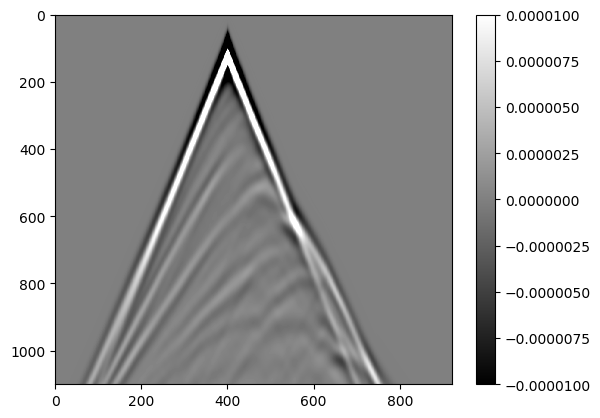

In [12]:
ishot = 5
trcs = getblock(d,5)
imshow(trcs,aspect="auto",cmap="gray");clim(-1e-5,1e-5);colorbar();

## Remove source field files on local disk

In [13]:
close(F)

## Remove workers

In [14]:
rmprocs(workers())

Task (done) @0x00002b2ac695ebf0